In [62]:
from keras.preprocessing import image, sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.wrappers import Bidirectional

from keras import backend as K
K.set_image_dim_ordering('th')

import numpy as np
import pandas as pd

import h5py
import glob
import pickle
import nltk
from tqdm import tqdm
import cv2
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# Inception V3 CNN (Encoder for image captioning)

## DataPreparation

### Get captions for all images in dataset

In [27]:
token_filepath = './Flickr8k/text/Flickr8k.token.txt'
captions_tmp = open(token_filepath, 'r').read().strip().split('\n')

captions = {}
for row in captions_tmp:
    title = row.split("\t")[0][:-2]
    text = row.split("\t")[1]
    if not(title in captions):
        captions[title] = []
        
    captions[title].append(text)

In [28]:
captions['3561130207_d1ed166daa.jpg']

['A crowd of girls at a concert .',
 'A crowd of people stand .',
 'Adoring girls watch the singer at the concert .',
 'a group of people smiling and dancing in a huddle group together .',
 'A large group of people are watching something , screaming , and taking pictures .']

### Get all pathes to train, val, test images

In [45]:
BATCH_SIZE = 32
path_to_images = 'Flickr8k/dataset/'

In [50]:
path_to_train_images_list = './Flickr8k/text/Flickr_8k.trainImages.txt'
train_images = list(set(open(path_to_train_images_list, 'r').read().strip().split('\n')))

print("train_images: ", len(train_images))

train_images:  6000


In [51]:
path_to_val_images_list = './Flickr8k/text/Flickr_8k.devImages.txt'
val_images = list(set(open(path_to_val_images_list, 'r').read().strip().split('\n')))

print("val_images: ", len(val_images))

val_images:  1000


In [52]:
path_to_test_images_list = './Flickr8k/text/Flickr_8k.testImages.txt'
test_images = list(set(open(path_to_test_images_list, 'r').read().strip().split('\n')))

print("test_images: ", len(test_images))

test_images:  1000


In [47]:
def get_full_path_to_img(img_title):
    return path_to_images + img_title

In [143]:
def get_numpy_img(img_title):
    return cv2.resize(cv2.imread(get_full_path_to_img(img_title)), (300, 300))  
#     return image.load_img(get_full_path_to_img(img_title), target_size=(300, 300))

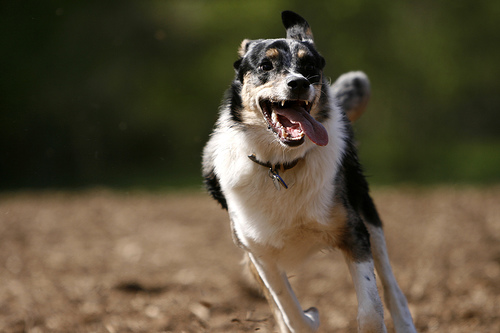

In [144]:
Image.open(get_full_path_to_img(train_images[1]))

### Preprocess

In [94]:
# Could be used later for data augmentation

# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         width_shift_range=0.2, 
#         height_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# def process(X, train=True):
#     if train:
#         return train_datagen.flow(X, batch_size=BATCH_SIZE)
#     else:
#         return test_datagen.flow(X, batch_size=BATCH_SIZE)
    
# im = cv2.imread(get_full_path_to_img(train_images[1]))
# im_procesed = process( np.array([im]), np.array([0]) )

# # print(im_procesed.index_array)

# # for i in im_procesed:
# #     print(i.shape)
# #     plt.imshow(i[0])

In [156]:
def preprocess_input(x):
    x /= 255.
#     x -= 0.5
    x *= 2.
    return x

In [157]:
def preprocess(image_title):
    img = get_numpy_img(image_title)
    x = image.img_to_array(img)
        
    x = np.expand_dims(x, axis=0)    
    x = preprocess_input(x)
    
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


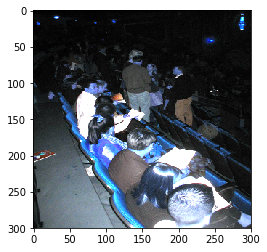

In [173]:
preprocessed_img = np.squeeze(preprocess(train_images[34])) 
preprocessed_img = np.rollaxis(preprocessed_img, 0, 3)

plt.imshow(preprocessed_img)

## InceptionV3 Model

### Cut off the last layer of the keras InceptionV3

In [188]:
inception_model = InceptionV3(weights='imagenet')

In [189]:
from keras.models import Model

# We do not need dense(prediction) layer from InceptionV3 model,
# so remove it and create own instance of the InceptionV3 which output will be 2048 neurons

new_input = model.input
hidden_layer = model.layers[-2].output

model = Model(new_input, hidden_layer)

In [190]:
pre_tmp = model.predict(preprocess(train_images[0]))

In [191]:
pre_tmp.shape

(1, 2048)

###  Encode ...

In [193]:
def encode(image):
    image = preprocess(image)
    enc_tmp = model_new.predict(image)
    enc_tmp = np.reshape(enc_tmp, enc_tmp.shape[1])
    return enc_tmp

In [ ]:
encoding_train = {}

for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
